In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
x = 7
y = 7
z = 5

my_j = ((z+1) % 3) + 1
my_p = 0.25 + 0.5 * ((x+1) / 10)
my_gamma = 0.2 + 0.5 * (y / 10)

In [3]:
class GridWorld(object):

    def __init__(self, my_j, my_p, my_gamma):

        # Attributes defining the Gridworld

        # Personalised variables
        self.my_j = my_j
        self.my_p = my_p
        self.my_gamma = my_gamma

        # Shape of the gridworld
        self.shape = (6,6)

        # Locations of the obstacles
        self.obstacle_locs = [(1, 1), (3, 1), (4, 1),
                              (4, 2), (2, 3), (4, 4), (2, 5)]

        # Locations for the absorbing states
        self.absorbing_locs = [(1, 0), (4, 3)]

        # Rewards for each of the absorbing states
        self.special_rewards = [10, -100]

        # Reward for all the other states
        self.default_reward = -1

        # Action names - Action 0 is 'N', 1 is 'E' etc
        self.action_names = ['N', 'E', 'S', 'W']

        # Number of actions
        self.action_size = len(self.action_names)

        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        # Change this so that it succeeds with prob p
        self.action_randomizing_array = [
            my_p, (1 - my_p) / 3, (1 - my_p) / 3, (1 - my_p) / 3]

        ############################################


        # Internal State

        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()

        # Number of valid states in the gridworld
        self.state_size = state_size

        # Transition operator (3D tensor)
        self.T = T  # T[st+1, st, a]

        # Reward function (3D tensor)
        self.R = R  # R[st+1, st, a]

        # Absorbing states
        self.absorbing = absorbing

        # The locations of the valid states 
        self.locs = locs  # State 0 is at the location self.locs[0]

        # Starting location
        self.starting_loc = (0, 3)
        start_index = 6
        while(start_index == 6 or start_index == 21):
            start_index = np.random.randint(0, 29)
        self.starting_loc = locs[start_index]

        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);

        # Locating the initial state
        self.initial = np.zeros((1, len(locs)))
        self.initial[0, self.starting_state] = 1

        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape)
        for ob in self.obstacle_locs:
            self.walls[ob] =- 50

        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1

        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]

        # Illustrating the grid world
        self.paint_maps()

    ################################
    
    # Getters

    def get_transition_matrix(self):
        return self.T


    def get_reward_matrix(self):
        return self.R


    ################################



    # Methods

    # Dynamic Programming methods

    def policy_iteration(self, discount, threshold = 0.0001):
        # Transition and reward matrices
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()

        # Initialisation - uniform policy
        policy = 0.25 * np.ones((self.state_size, self.action_size))
        epochs = 0
        policy_stable = False  # Condition to stop the main loop

        while not(policy_stable):

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval

            # False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):

                # If not an absorbing state
                if not(self.absorbing[0, state_idx]):

                    # Store the old action
                    old_action = np.argmax(policy[state_idx, :])

                    # Compute Q value
                    Q = np.zeros(4)  # Initialise with value 0

                    for state_idx_prime in range(policy.shape[0]):
                        Q += (T[state_idx_prime, state_idx, :] *
                              (R[state_idx_prime, state_idx, :] +
                               discount * V[state_idx_prime]))

                    # Compute corresponding policy
                    new_policy = np.zeros(4)

                    # Greedy algorithm
                    new_policy[np.argmax(Q)] = 1
                    policy[state_idx] = new_policy

                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False

        return V, policy, epochs


    def policy_evaluation(self, policy, threshold, discount):
        # Make sure delta is bigger than the threshold to start with
        delta = 2 * threshold

        # Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()

        # The value is initialised at 0
        V = np.zeros(policy.shape[0])

        # Deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)

        epoch = 0

        while delta > threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):

                # If it is one of the absorbing states, ignore
                if(self.absorbing[0, state_idx]):
                    continue

                # Accumulator variable for the Value of a state
                tmpV = 0

                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = (tmpQ +
                                T[state_idx_prime, state_idx, action_idx] *
                                (R[state_idx_prime, state_idx, action_idx] +
                                 discount * V[state_idx_prime]))

                    tmpV += policy[state_idx, action_idx] * tmpQ

                Vnew[state_idx] = tmpV

            delta = max(abs(Vnew - V))
            V = np.copy(Vnew)

        return V, epoch
    

    # Temporal Difference methods
    def TD_policy_improvement(self, DP_V, repeats, gamma, alpha, epsilon, episodes):
        policy = 0.25*np.ones((self.state_size, self.action_size))

        # Q and V functions initialised to zero
        Q = np.zeros(policy.shape)
        V = np.zeros(policy.shape[0])

        # Check for convergence and whether policy changes
        policy_stable = False
        check_stable = True
        check_converge = True

        no_traces = 0
        limit = 0
        init_alpha = alpha

        # Rewards earned from trace, standard deviation of rewards and estimation error
        rewards_over_policies = []
        rewards_std = []
        rmse = []

        while(limit < episodes):
            limit += 1

            # GLIE
            dec_eps = epsilon/(limit**0.2)

            # Robbins-Monroe alpha
            alpha = init_alpha/(limit**0.5)

            # Help with convergence
            if(limit > (0.99 * episodes)):
                dec_eps = 0

            # Policy evaluation
            Q, V, no_tr, m_rewards, reward_std = self.TD_policy_evaluation(
                policy, Q, V, DP_V, repeats, gamma, alpha
            )
            no_traces += no_tr
            rewards_over_policies.append(m_rewards)
            rewards_std.append(reward_std)

            # Estimation error
            error = V - DP_V
            my_rmse = np.sqrt(np.mean(error**2))
            rmse.append(my_rmse)

            policy_stable = True

            for s in range(policy.shape[0]):
                if not(self.absorbing[0, s]):

                    old_dir = np.argmax(policy[s, :])
                    new_policy = np.zeros(4)

                    Q_my_state = Q[s, :]
                    new_dir = np.argmax(Q_my_state)

                    # Epsilon greedy
                    suboptimal_actions = dec_eps/4
                    new_policy = suboptimal_actions * np.ones(4)
                    new_policy[new_dir] = (1-dec_eps) + dec_eps/4

                    policy[s] = new_policy

                    if old_dir != new_dir:
                        policy_stable = False

            if(policy_stable and check_stable):
                check_stable = False
                check_converge = False

        if(check_converge):
            print("Did not converge within lim")

        return Q, V, policy, no_traces, rewards_over_policies, limit, rewards_std, rmse


    def TD_policy_evaluation(self, policy, Q, V, DP_V, repeats, gamma, alpha):
        no_traces = 0
        agent_reward = []

        for i in range(repeats):
            no_traces += 1

            trace_states, trace_actions, trace_rewards = self.MC_trace(policy)

            temp_reward = 0
            exponent = 0

            # Loop through all the states in trace
            for j in range(len(trace_rewards)):

                # Backward discounting
                temp_reward += (gamma ** exponent) * trace_rewards[-1-j]

                exponent += 1

                my_state = trace_states[j]
                my_reward = trace_rewards[j]
                my_action = trace_actions[j]
                my_dir = np.argmax(my_action)

                next_state = trace_states[j+1]
                if (j < (len(trace_rewards)-1)):
                    next_dir = np.argmax(trace_actions[j+1])
                else:
                    next_dir = 1

                if(alpha == 0):
                    alpha = 1/no_traces
                
                V[my_state] += alpha*(my_reward + gamma*V[next_state] - V[my_state])
                Q[my_state,my_dir] += (
                    alpha * (my_reward + gamma * Q[next_state, next_dir] -
                             Q[my_state, my_dir])
                )

            agent_reward.append(temp_reward)

        mean_reward = np.mean(agent_reward)
        reward_std = np.std(agent_reward)

        return Q, V, no_traces, mean_reward, reward_std


    # Monte Carlo methods
    def MC_policy_improvement(self, DP_V, repeats, gamma, alpha, epsilon, episodes):
        policy = 0.25*np.ones((self.state_size, self.action_size))

        Q = np.zeros(policy.shape)
        V = np.zeros(policy.shape[0])

        rewards_over_policies = []
        rewards_std = []
        rmse = []

        policy_stable = False
        check_converge = True
        no_traces = 0
        limit = 0

        while (limit < episodes):
            limit += 1

            # GLIE
            dec_eps = epsilon / (limit**0.2)

            if(limit > (0.99 * episodes)):
                dec_eps = 0

            # Policy evaluation
            Q, V, no_tr, m_reward, reward_std = self.MC_policy_evaluation(
                policy, Q, V, DP_V, repeats, gamma, alpha
            )
            no_traces += no_tr
            rewards_over_policies.append(m_reward)
            rewards_std.append(reward_std)

            error = V - DP_V
            my_rmse = np.sqrt(np.mean(error**2))
            rmse.append(my_rmse)

            policy_stable = True
            check_stable = True

            for s in range(policy.shape[0]):
                if not(self.absorbing[0, s]):

                    old_dir = np.argmax(policy[s, :])
                    new_policy = np.zeros(4)

                    Q_my_state = Q[s, :]
                    new_dir = np.argmax(Q_my_state)

                    # Epsilon greedy
                    suboptimal_actions = dec_eps / 4
                    new_policy = suboptimal_actions * np.ones(4)
                    new_policy[new_dir] = (1 - dec_eps) + dec_eps / 4

                    policy[s] = new_policy

                    if old_dir != new_dir:
                        policy_stable = False

            if(policy_stable and check_stable):
                check_stable = False
                check_converge = False

        if(check_converge):
            print("Did not converge within lim")

        return (Q, V, policy, no_traces, rewards_over_policies,
                limit, rewards_std, rmse)


    def MC_policy_evaluation(self, policy, Q, V, DP_V, repeats, gamma, alpha):
        no_traces = 0
        agent_reward = []

        for i in range(repeats):
            no_traces += 1
            trace_states, trace_actions, trace_rewards = self.MC_trace(policy)
            temp_reward = 0
            exponent = 0

            # Loop through all the states in trace
            for j in range(len(trace_rewards)):
                # Backward discounting
                temp_reward += (gamma**exponent) * trace_rewards[-1-j]
                exponent += 1

                my_state = trace_states[j]
                my_action = trace_actions[j]
                my_dir = np.argmax(my_action)

                temp_V = 0
                power = 0

                for k in range(j, len(trace_rewards)):
                    temp_V += (gamma**power)*trace_rewards[k]
                    power += 1

                if(alpha == 0):
                    alpha = 1/no_traces

                Q[my_state, my_dir] += alpha * (temp_V - Q[my_state, my_dir])
                V[my_state] += alpha*(temp_V - V[my_state])

            agent_reward.append(temp_reward)

        mean_reward = np.mean(agent_reward)
        reward_std = np.std(agent_reward)

        return Q, V, no_traces, mean_reward, reward_std

    def MC_trace(self, policy):
        # Generate start position
        start_index = 6
        while(start_index == 6 or start_index == 21):
            start_index = np.random.randint(0, 29)

        if(start_index == 6 or start_index == 21):
            print("Invalid start state")

        locations, neighbours, absorbing = self.get_topology()
        trace_states = [start_index]
        trace_actions = []
        trace_rewards = []

        next_state = start_index

        isNotAbsorbing = True
        while isNotAbsorbing:
            
            North_c = policy[next_state, 0]
            East_c = North_c + policy[next_state, 1]
            South_c = East_c + policy[next_state, 2]
            West_c = 2

            rand_num = np.random.rand()
            # Pick an action based on the given policy
            if(rand_num < West_c):
                current_action = [0, 0, 0, 1]
                if(rand_num < South_c):
                    current_action = [0, 0, 1, 0]
                    if(rand_num < East_c):
                        current_action = [0, 1, 0, 0]
                        if(rand_num < North_c):
                            current_action = [1, 0, 0, 0]

            current_direction = np.argmax(current_action)

            # Probability of actually moving in desired direction
            rand_num = np.random.rand()
            if(rand_num < my_p):
                actual_action = current_action
                actual_direction = current_direction
            else:
                actual_direction = current_direction
                while(actual_direction == current_direction):
                    actual_direction = np.random.randint(0, 4)
                actual_action = [0, 0, 0, 0]
                actual_action[actual_direction] = 1

            next_state = neighbours[trace_states[-1], actual_direction]
            next_state = int(next_state)

            trace_states.append(next_state)
            trace_actions.append(actual_action)

            if(next_state == 6):
                reward = 10
            elif(next_state == 21):
                reward = -100
            else:
                reward = -1

            trace_rewards.append(reward)

            isNotAbsorbing = not(self.absorbing[0, next_state])

        return trace_states, trace_actions, trace_rewards


    ##########################


    # Internal Drawing Functions

    def draw_opt_val_policy(self, Value, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W

        # Set to (5,5) for screenshot
        plt.figure(figsize=(4, 4), dpi=100)
        # plt.figure()

        # Create the graph of the grid
        plt.imshow(self.walls+self.rewarders + self.absorbers)
        # plt.hold('on')
        for state, action in enumerate(Policy):
            # If absorbing state, don't plot any action
            if(self.absorbing[0, state]):
                continue
            arrows = [r"$\uparrow$", r"$\rightarrow$",
                      r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]  # Take the corresponding action
            location = self.locs[state]  # Compute its location on graph
            plt.text(location[1], location[0], action_arrow,
                     ha='center', va='top', fontsize=11)

        for state, value in enumerate(Value):
            # If it is an absorbing state, don't plot any value
            if(self.absorbing[0, state]):
                continue
            location = self.locs[state]  # Compute the value location on graph
            plt.text(location[1], location[0], round(value, 2),
                     ha='center', va='bottom')
        plt.show()


    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W

        # Set to (5,5) for screenshot
        plt.figure(figsize=(5, 5), dpi=100)
        # plt.figure()

        plt.imshow(self.walls+self.rewarders + self.absorbers)
        # plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0, state]):
                continue
            arrows = [r"$\uparrow$", r"$\rightarrow$",
                      r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]  # Take the corresponding action
            location = self.locs[state]  # Compute its location on graph
            plt.text(location[1], location[0], action_arrow,
                     ha='center', va='center', fontsize=11)
        plt.show()


    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        # plt.figure()
        plt.figure(figsize=(5, 5), dpi=100)

        plt.imshow(self.walls+self.rewarders + self.absorbers)
        for state, value in enumerate(Value):
            if(self.absorbing[0, state]):
                continue
            location = self.locs[state]
            plt.text(location[1], location[0], round(value, 2),
                     ha='center', va='center', fontsize=11)
        plt.show()


    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20, 8))
        for subplot in range(len(Policy)):
            ax = plt.subplot(n_columns, n_lines, subplot + 1)
            ax.imshow(self.walls+self.rewarders + self.absorbers)
            for state, action in enumerate(Policy[subplot]):
                if(self.absorbing[0, state]):
                    continue
                arrows = [r"$\uparrow$", r"$\rightarrow$",
                          r"$\downarrow$", r"$\leftarrow$"]
                action_arrow = arrows[action]  # Take the corresponding action
                location = self.locs[state]  # Compute its location on graph
                plt.text(location[1], location[0], action_arrow,
                         ha='center', va='center')
            ax.title.set_text(title[subplot])
        plt.show()


    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20, 8))
        for subplot in range(len(Value)):
            ax = plt.subplot(n_columns, n_lines, subplot+1)
            ax.imshow(self.walls+self.rewarders + self.absorbers)
            for state, value in enumerate(Value[subplot]):
                if(self.absorbing[0, state]):
                    continue
                location = self.locs[state]
                plt.text(location[1], location[0], round(value, 1),
                         ha='center', va='center')
            ax.title.set_text(title[subplot])
        plt.show()

    ##########################
    

    ########### Internal Helper Functions #####################

    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1, 3, 2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1, 3, 3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()


    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()

        # Get the number of states
        S = len(locations)

        # Initialise the transition matrix
        T = np.zeros((S, S, 4))

        for action in range(4):
            for effect in range(4):
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1

                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state, prior_state, action] = (
                        T[post_state, prior_state, action] + prob
                    )

        # Build the reward matrix
        R = self.default_reward*np.ones((S, S, 4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i], locations)
            R[post_state, :, :] = sr

        return S, T, R, absorbing, locations


    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]

        locs = []
        neighbour_locs = []

        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i, j)

                # Append it to the valid state locations
                if(self.is_location(loc)):
                    locs.append(loc)

                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc, direction)
                                        for direction in [
                                            'nr', 'ea', 'so', 'we'
                                        ]]
                    neighbour_locs.append(local_neighbours)

        # Translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states, 4))

        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]

                # Turn location into a state number
                nstate = self.loc_to_state(nloc, locs)

                # Insert into neighbour matrix
                state_neighbours[state, direction] = nstate

        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1, num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a, locs)
            absorbing[0, absorbing_state] = 1

        return locs, state_neighbours, absorbing


    def loc_to_state(self,loc,locs):
        # Takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0] < 0 or loc[1] < 0 or
           loc[0] > self.shape[0]-1 or
           loc[1] > self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
            return True


    def get_neighbour(self,loc,direction):
        # Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]

        nr = (i-1, j)
        ea = (i, j+1)
        so = (i+1, j)
        we = (i, j-1)

        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            # default is to return to the same location
            return loc

Creating the Grid world, represented as:



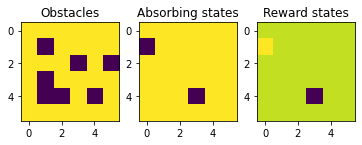

In [4]:
# Define the grid
print("Creating the Grid world, represented as:\n")

x = 7
y = 7
z = 5

my_j = ((z + 1) % 3) + 1
my_p = 0.25 + 0.5 * ((x + 1)/10)
my_gamma = 0.2 + 0.5 * (y / 10)

grid = GridWorld(my_j, my_p, my_gamma)

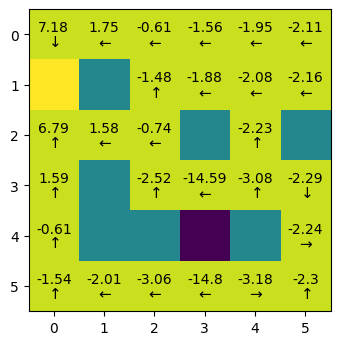

In [5]:
# Dynamic programming approach
DP_V, DP_policy, DP_epochs = grid.policy_iteration(my_gamma)
grid.draw_opt_val_policy(
    DP_V, np.array(
        [np.argmax(DP_policy[row, :]) for row in range(grid.state_size)]
    ))

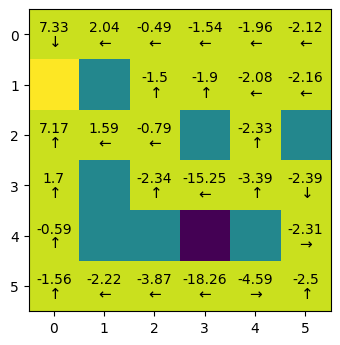

Before: 20:41
After: 20:44


In [6]:
# Monte Carlo
before = datetime.datetime.now()

# Parameters
repeats = 30
alpha = 0.1
epsilon = 0.6
episodes = 300
obs = 30

all_MC_V = []
all_MC_policy = np.zeros((grid.state_size, grid.action_size))
all_MC_R = []
all_MC_rmse = []

for i in range(obs):
    MC_Q, MC_V, MC_policy, MC_no_traces, MC_all_R, MC_lim, MC_R_std, MC_rmse = grid.MC_policy_improvement(DP_V, repeats, my_gamma, alpha, epsilon, episodes)
    all_MC_V.append(MC_V)
    all_MC_policy = np.add(all_MC_policy, MC_policy)
    all_MC_R.append(MC_all_R)
    all_MC_rmse.append(MC_rmse)

# Average values for each episode
mean_MC_V = np.mean(all_MC_V, axis=0)
mean_MC_R = np.mean(all_MC_R, axis=0)
std_MC_R = np.std(all_MC_R, axis=0)
mean_MC_rmse = np.mean(all_MC_rmse, axis=0)
MC_directions = np.argmax(all_MC_policy, axis=1)

# Average policy
MC_policy = np.zeros((grid.state_size, grid.action_size))
for i in range(len(MC_directions)):
    MC_policy[i, MC_directions[i]] = 1

grid.draw_opt_val_policy(
    mean_MC_V, np.array(
        [np.argmax(MC_policy[row, :]) for row in range(grid.state_size)]))

after = datetime.datetime.now()

print('Before: {}:{}'.format(before.hour, before.minute))
print('After: {}:{}'.format(after.hour, after.minute))

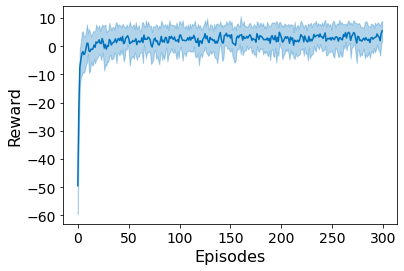

In [7]:
# Learning curve of MC

plt.figure()
plt.plot(np.arange(MC_lim), mean_MC_R, color='#0072BD', label='MC')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

upper_y = np.add(mean_MC_R, std_MC_R)
lower_y = np.subtract(mean_MC_R, std_MC_R)

plt.fill_between(np.arange(MC_lim), lower_y, upper_y, color='#0072BD', alpha = 0.3)

plt.show()

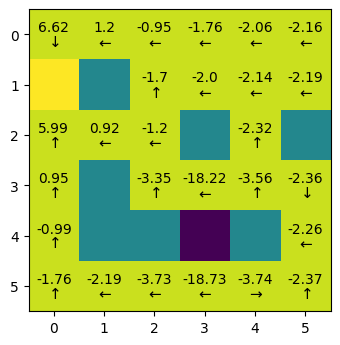

Before: 20:44
After: 20:46


In [8]:
# Temporal Difference learning approach
before = datetime.datetime.now()

# Parameters
repeats = 30
alpha = 0.1
epsilon = 0.6
episodes = 300
obs = 30

all_TD_V = []
all_TD_policy = np.zeros((grid.state_size, grid.action_size))
all_TD_R = []
all_TD_rmse = []

for i in range(obs):
    TD_Q, TD_V, TD_policy, TD_no_traces, TD_all_R, TD_lim, TD_R_std, TD_rmse = grid.TD_policy_improvement(DP_V, repeats, my_gamma, alpha, epsilon, episodes)
    all_TD_V.append(TD_V)
    all_TD_policy = np.add(all_TD_policy, TD_policy)
    all_TD_R.append(TD_all_R)
    all_TD_rmse.append(TD_rmse)

mean_TD_V = np.mean(all_TD_V, axis=0)
mean_TD_R = np.mean(all_TD_R, axis=0)
std_TD_R = np.std(all_TD_R, axis=0)
mean_TD_rmse = np.mean(all_TD_rmse, axis=0)
TD_directions = np.argmax(all_TD_policy, axis=1)

TD_policy = np.zeros((grid.state_size, grid.action_size))
for i in range(len(TD_directions)):
    TD_policy[i, TD_directions[i]] = 1

grid.draw_opt_val_policy(
    mean_TD_V, np.array(
        [np.argmax(TD_policy[row, :]) for row in range(grid.state_size)]
    ))

after = datetime.datetime.now()

print('Before: {}:{}'.format(before.hour, before.minute))
print('After: {}:{}'.format(after.hour, after.minute))

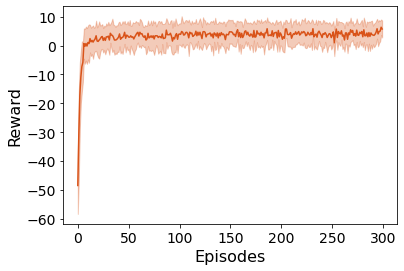

In [9]:
# Learning curve of TD over 50 observations

plt.figure()
plt.plot(np.arange(TD_lim), mean_TD_R, color='#D95319', label='TD')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

upper_y = np.add(mean_TD_R, std_TD_R)
lower_y = np.subtract(mean_TD_R, std_TD_R)

plt.fill_between(np.arange(MC_lim), lower_y, upper_y,
                 color='#D95319', alpha=0.3)

plt.show()

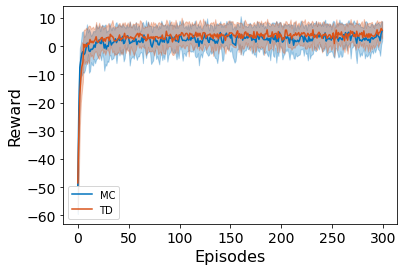

In [10]:
# Plot MC and TD learning curves on same graph

plt.figure()
plt.plot(np.arange(MC_lim), mean_MC_R, color='#0072BD', label='MC')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

upper_y = np.add(mean_MC_R, std_MC_R)
lower_y = np.subtract(mean_MC_R, std_MC_R)

plt.fill_between(np.arange(MC_lim), lower_y, upper_y, color='#0072BD', alpha=0.3)

plt.plot(np.arange(TD_lim), mean_TD_R, color='#D95319', label='TD')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

upper_y = np.add(mean_TD_R, std_TD_R)
lower_y = np.subtract(mean_TD_R, std_TD_R)

plt.fill_between(np.arange(MC_lim), lower_y, upper_y, color='#D95319', alpha=0.3)

plt.legend()
plt.show()

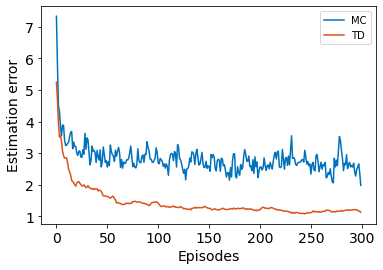

In [11]:
# Plot MC and TD rmse over episodes on same graph

plt.figure()
plt.plot(np.arange(MC_lim), mean_MC_rmse, color='#0072BD', label='MC')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel("Estimation error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(np.arange(TD_lim), mean_TD_rmse, color='#D95319', label='TD')
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Estimation error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()
plt.show()

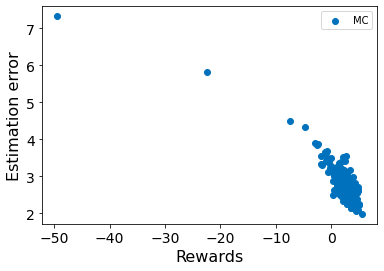

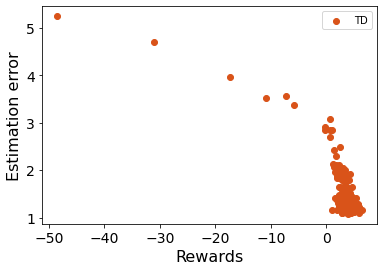

In [12]:
# Plot MC and TD rmse over reward

plt.figure()

plt.scatter(mean_MC_R, mean_MC_rmse, color='#0072BD', label='MC')
plt.xlabel("Rewards", fontsize=16)
plt.ylabel("Estimation error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()
plt.show()


plt.figure()
plt.scatter(mean_TD_R, mean_TD_rmse, color='#D95319', label='TD')
plt.xlabel("Rewards", fontsize=16)
plt.ylabel("Estimation error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend()
plt.show()